# 1.사진 준비하기

사진을 촬영하거나,다운로드 받아 지정 경로에 저장한다.
```
aiffel
├── camera_sticker
        └── models
        └── images
                └── image.jpg
```

# 2.사진 편집하기(사이즈,색상)

opecv - 영상관련 쪽에 자주 사용하는 라이브러리   
matplotlib - 이미지 출력 때 사용    
numpy - 행렬식 계산 라이브러리

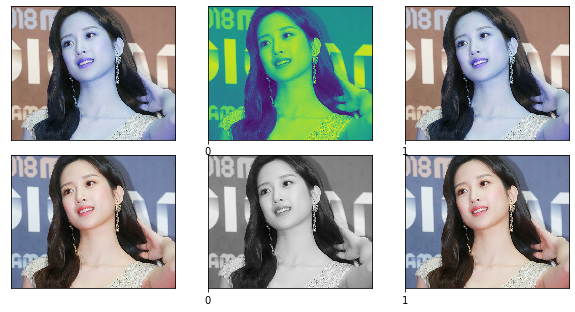

In [631]:
import cv2 #openCV
import matplotlib.pyplot as plt # 매트플롯라이브러리
import numpy as np #
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/img1.jpg'#파일경로

fig = plt.figure(figsize=(10,10)) 

for i in range(-1,2):
    img_bgr = cv2.imread(my_image_path,i)    #- OpenCV로 이미지를 읽어서(이미지경로,-1 or 0 or 1)
    #img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
    ax = fig.add_subplot(2, 3, i+2)
    ax.imshow(img_bgr)
    ax.set_xticks([i]), ax.set_yticks([]) 
    
    ax = fig.add_subplot(1, 3, i+2)
    ax.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    ax.set_xticks([i]), ax.set_yticks([])
    
        
plt.show()


cv2.IMREAD_COLOR : 이미지 파일을 Color로 읽어들입니다. 투명한 부분은 무시되며, Default값입니다.   
cv2.IMREAD_GRAYSCALE : 이미지를 Grayscale로 읽어 들입니다. 실제 이미지 처리시 중간단계로 많이 사용합니다.   
cv2.IMREAD_UNCHANGED : 이미지파일을 alpha channel까지 포함하여 읽어 들입니다.   

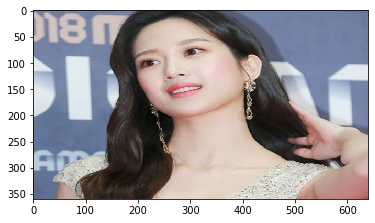

In [632]:
# img_rgb에 조절된 사진 저장
img_bgr = cv2.resize(img_bgr, (640, 360))
img_rgb=cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

img_show = img_bgr.copy()#- 출력용 이미지 별도 보관

dlib 의 face detector는 HOG feature를 사용해서 SVM의 sliding window로 얼굴을 찾습니다.   
cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) bgr -> RGB 변환   
dlib_rects = detector_hog(img_rgb, 1) -> img_rgb의 이미지에서 얼굴 detector한다.    

# 3.얼굴의 bounding box 찾기

### detector를 이용해서 얼굴의 bounding box 추출

rectangles[[(198, 32) (364, 198)]]


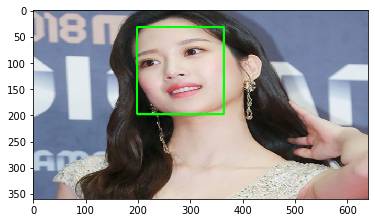

In [633]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- dlib을 활용해 hog detector를 선언
dlib_rects = detector_hog(img_rgb, 3)   #- #detector를 이용해서 얼굴의 bounding box를 추출
# 두 번째 파라미터는 이미지 피라미드의 수, 이미지를 upsampling 방법을 통해 크기를 키우는 것을 이미지 피라미드라고 합니다.

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

imshow에 바운딩 박스가 적용된 사진으로 저장한다.

# 4.face landmark 찾기( keypoint 찾기)

detection 의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지를 이용한다.   
Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 부른다.
keypoint를 찾는 알고리즘은 크게 2가지
 - top-down : bounding box를 찾고 box 내부의 keypoint를 예측
 - bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

우리는 TOP-DOWN방식 사용


### Dlib landmark localization

landmark localization란 사람의 얼굴 사진을 보고 이목구비의 위치를 추론하는 것   
아래 68개의 이목구비 위치를 찾을수 있다.   
Dlib은 ibug 300-W 데이터셋으로 학습한 pretrained model 을 제공한다.(따로 받아야된다.) 


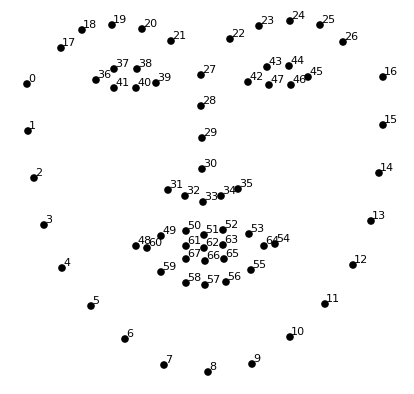

In [634]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)# ibug 300-W 데이터셋으로 학습한 pretrained model 가져오기
print(landmark_predictor)

위와 같이 bug 300-W 데이터셋으로 학습한 pretrained model 가져온다

In [635]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)#(얼굴이미지, bounding box좌표정보)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) # 68갸의 KEYPOINT 

68


68개의 keypoint를 가진다.

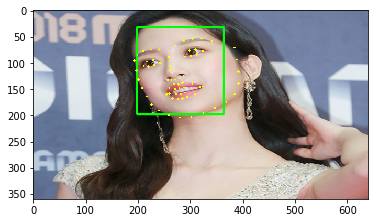

In [636]:
# 찾은 keypoint좌표를 가지고 이미지에 적용한다.
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
       cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 5. 스티커 설정하기

# x,y값 설정하기 (바운딩 박스 좌상단)

In [637]:
#x,y값 설정하기 (바운딩 박스 좌상단)
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    #바운딩 박스 좌표(l,t) (r,b)
    #print (landmark[1]) # 왼쪽 광대
    #x = landmark[0][0]
    #y = landmark[1][1] 
    x = l
    y = t
    
    w = dlib_rect.width() #바운딩박스 높이
    h = dlib_rect.width() #바운딩박스 너비
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('바운딩박스:','(w,h) : (%d,%d)'%(w,h))

(x,y) : (198,32)
바운딩박스: (w,h) : (167,167)


# 스티커 사이즈 조절

In [638]:
#스티커 사이즈 조절
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print ("(가로,세로,rgb)")
print (img_sticker.shape)

(가로,세로,rgb)
(167, 167, 3)


# 스티커 좌표 조절(refined_x,refined_y)

In [639]:
#스티커 좌표 조절(refined_x,refined_y)
refined_x = x
refined_y = y
#refined_x = x - w // 2  # left
#refined_y = y - h      # top
print ('스티커_좌표 (x,y):(%d,%d)'%(refined_x, refined_y))

스티커_좌표 (x,y):(198,32)


# 스티커의 y좌표가 음수일 경우

In [640]:
#스티커의 y좌표가 음수일 경우
if(refined_y<0):
    img_sticker = img_sticker[-refined_y:]
    refined_y =0

print ('스티커Shape:' ,img_sticker.shape)

스티커Shape: (167, 167, 3)


스티커가 얼굴사진 밖의 좌표를 찍을때 y값을 0으로 설정해준다.

# 스티커 영역크기 조절

In [641]:
#스티커 영역크기 조절
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
print(refined_y,refined_y+img_sticker.shape[0])
print(refined_x,refined_x+img_sticker.shape[0])


32 199
198 365


# 스티커 붙이기

<class 'numpy.ndarray'>
(167, 167, 3)
<class 'numpy.ndarray'>
(360, 640, 3)


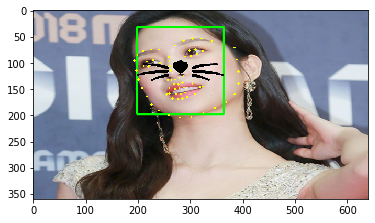

In [642]:
#스티커 붙이기
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

print(type(sticker_area)) # 스티커사진 범위
print(sticker_area.shape)
print(type(img_show))
print(img_show.shape) 


plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 사이즈 정규화

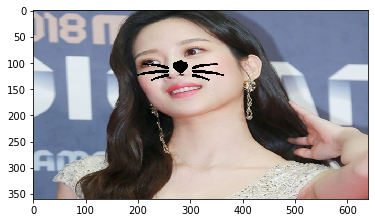

In [643]:
#사이즈 정규화
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 여러가지 사진 사용해보기

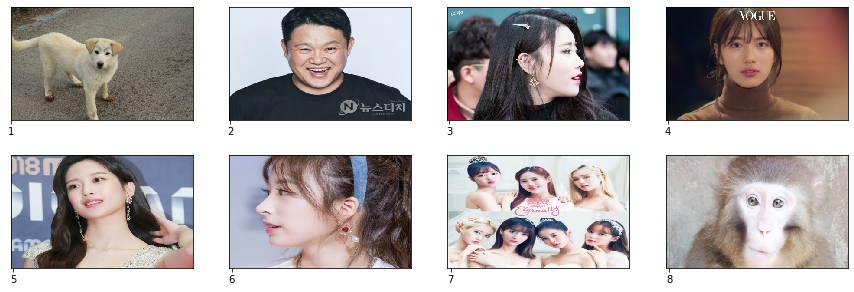

In [2]:
import cv2 #openCV
import matplotlib.pyplot as plt # 매트플롯라이브러리
import numpy as np #
import os
import glob

image_test_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/*.jpg'#이미지
images = glob.glob(image_test_path)# 이미지리스트
images_test_rgb=[]   

def imageOutput(images):
    i=0

    fig1 = plt.figure(figsize=(15,5))

    for image in images:
        i+=1
        image_test = cv2.imread(image)
        image_test = cv2.resize(image_test, (420, 260))
        ax = fig1.add_subplot(2, 4, i)
        image_test_rgb= cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)
        ax.imshow(image_test_rgb)
        ax.set_xticks([i]), ax.set_yticks([])
        
        images_test_rgb.append(image_test_rgb)
    plt.show()
    return images_test_rgb

images_test_rgb=imageOutput(images)

# 여러가지 사진(바운딩박스)

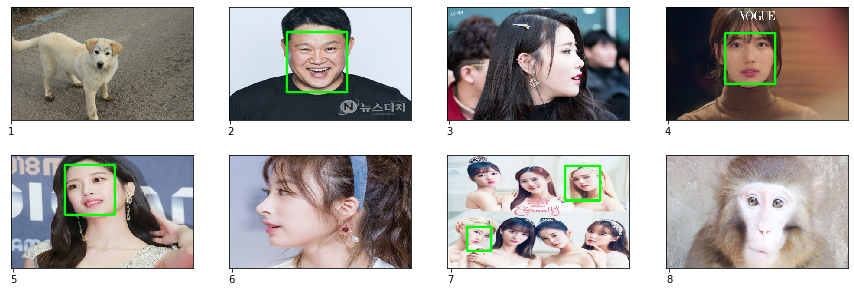

In [3]:
import dlib

def detectorHog(images):
    imgs_test_box=[]
    fig2 = plt.figure(figsize=(15,5))
    i=0
    ls_dlib_rects=[]
    for image in images: 
        i+=1
        img_show = image.copy()
        
        img_show =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
        detector_hog = dlib.get_frontal_face_detector()   #- dlib을 활용해 hog detector를 선언
        dlib_rects = detector_hog(image, 3)   #- #detector를 이용해서 얼굴의 bounding box를 추출
        # 두 번째 파라미터는 이미지 피라미드의 수, 이미지를 upsampling 방법을 통해 크기를 키우는 것을 이미지 피라미드라고 합니다.
        
        #print(dlib_rects)   # 찾은 얼굴영역 좌표

        for dlib_rect in dlib_rects:
            l = dlib_rect.left()
            t = dlib_rect.top()
            r = dlib_rect.right()
            b = dlib_rect.bottom()

            cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 4, lineType=cv2.LINE_AA)
        img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
        ax = fig2.add_subplot(2, 4, i)
        ax.imshow(img_show_rgb)
        ax.set_xticks([i]), ax.set_yticks([])
        imgs_test_box.append(img_show_rgb)
        ls_dlib_rects.append(dlib_rects)
           
    plt.show()
    return imgs_test_box,ls_dlib_rects

imgs_test_box,ls_dlib_rects = detectorHog(images_test_rgb)





dlib 의 face detector는 HOG feature를 사용해서 SVM의 sliding window로 얼굴을 찾을 경우    
강아지, 원숭이, 사람의 옆모습 인 경우 바운딩박스가 생성되지 않는다. dlib 의 face detector 경우 동물과 사람들 구별할수 있다.하지만 옆모습으로는 사람을 판단하지 못했다. 또한 한 이미지에 얼굴이 2개가 이상인경우 위 처럼 2개만 인식한 경우도 있고, 아예 인식을 못하는 경우도 있다. 아마 이미지가 작아서 제대로 동작하지 않는것같다.


In [4]:
#8개 그림에 대한 바운딩박스좌표
for dlib_rects in ls_dlib_rects:
    print(dlib_rects)

rectangles[]
rectangles[[(133, 57) (272, 196)]]
rectangles[]
rectangles[[(136, 60) (252, 176)]]
rectangles[[(124, 22) (239, 137)]]
rectangles[]
rectangles[[(46, 165) (102, 220)], [(272, 24) (353, 104)]]
rectangles[]


# 여러가지 사진(랜드마크)

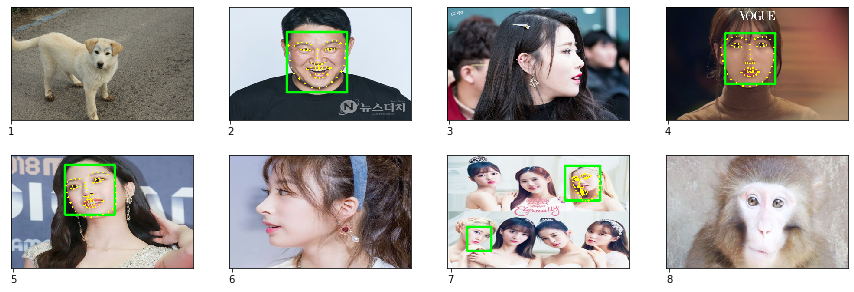

In [5]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)# ibug 300-W 데이터셋으로 학습한 pretrained model 가져오기
print(landmark_predictor)

lists_landmarks = []#각 이미지별 랜드마크 리스트
img_test_landmark = []
fig3 = plt.figure(figsize=(15,5))
i=0
for image in imgs_test_box: 
    i+=1
    
    list_landmarks = []
    img_show = image.copy()
    img_show =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    for dlib_rect in ls_dlib_rects[i-1]:
        points = landmark_predictor(image, dlib_rect)#(얼굴이미지, bounding box좌표정보)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

    # 찾은 keypoint좌표를 가지고 이미지에 적용한다.
    for landmark in list_landmarks:
        for idx, point in enumerate(list_points):
           cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

    img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    ax = fig3.add_subplot(2, 4, i)
    ax.imshow(img_show_rgb)
    ax.set_xticks([i]), ax.set_yticks([])
    lists_landmarks.append(list_landmarks)#총 7개의 68개의 랜드마크 리스트
    img_test_landmark.append(img_show_rgb) # 랜드마크 표시된 이미지 리스트
plt.show()  

7번을 보면 바운딩박스를 가지고 있지만 랜드마크(keypoint)가 설정이 안되어 있다. 바운딩박스가 존재한다고 무조건 랜드마크가 설정되지는 않는것 같다. 또한 얼굴사이즈가 작을수록 랜드마크(keypoint)위치의 정확도가 떨어진다.

In [648]:
#8개 그림에 대한 랜드마크 좌표
for landmarks in lists_landmarks:
    print(landmarks)



[]
[[(137, 88), (139, 105), (140, 122), (143, 138), (150, 153), (162, 165), (175, 175), (191, 184), (208, 186), (224, 183), (237, 173), (249, 162), (259, 149), (265, 134), (267, 117), (267, 101), (268, 84), (150, 88), (158, 82), (168, 81), (179, 82), (190, 86), (217, 85), (227, 80), (237, 78), (248, 78), (257, 83), (204, 97), (204, 107), (204, 117), (205, 127), (190, 130), (197, 131), (206, 134), (214, 131), (221, 128), (165, 98), (173, 97), (180, 97), (187, 100), (180, 100), (172, 100), (222, 99), (228, 96), (236, 95), (243, 96), (236, 98), (229, 99), (178, 142), (189, 139), (199, 138), (207, 139), (215, 138), (225, 137), (235, 140), (227, 155), (217, 162), (208, 163), (199, 162), (188, 155), (182, 143), (199, 142), (207, 143), (215, 142), (231, 141), (216, 154), (207, 155), (199, 154)]]
[]
[[(127, 93), (128, 109), (132, 125), (136, 140), (142, 155), (151, 168), (163, 177), (178, 183), (194, 184), (209, 181), (222, 174), (233, 163), (240, 150), (245, 136), (248, 122), (250, 107), (249

# 여러 사진 한번에 수염 붙이기(실패!)

(206, 134)
스티커위치: (x,y) : (206,206)
바운딩박스: (w,h) : (140,140)
(가로,세로,rgb) (140, 140, 3)
스티커_좌표 (x,y):(136,66)
스티커Shape: (140, 140, 3)
66 206
136 276
<class 'numpy.ndarray'>
(140, 140, 3)
<class 'numpy.ndarray'>
(260, 420, 3)


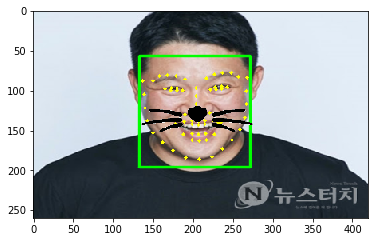

In [652]:
#x,y값 설정하기 (바운딩 박스 좌상단)

img_show = img_test_landmark[1]
img_show = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
for dlib_rect, landmark in zip(ls_dlib_rects[1], lists_landmarks[1]):
    #바운딩 박스 좌표(l,t) (r,b)
    print (landmark[33]) # nose tip index : 33
    x = landmark[33][0]
    y = landmark[33][0]
    w = dlib_rect.width() #바운딩박스 높이
    h = dlib_rect.width() #바운딩박스 너비
    print ('스티커위치: (x,y) : (%d,%d)'%(x,y))
    print ('바운딩박스:','(w,h) : (%d,%d)'%(w,h))

#스티커 사이즈 조절
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print ("(가로,세로,rgb)",img_sticker.shape)


#스티커 좌표 조절(refined_x,refined_y)
#refined_x = x
#refined_y = y
refined_x = x - w // 2  # left
refined_y = y - h      # top
print ('스티커_좌표 (x,y):(%d,%d)'%(refined_x, refined_y))

#스티커의 y좌표가 음수일 경우
if(refined_y<0):
    img_sticker = img_sticker[-refined_y:]
    refined_y =0
if(refined_x<0):
    img_sticker = img_sticker[-refined_x:]
    refined_x =0



print ('스티커Shape:' ,img_sticker.shape)

#스티커 영역크기 조절
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
print(refined_y,refined_y+img_sticker.shape[0])
print(refined_x,refined_x+img_sticker.shape[0])

#스티커 붙이기
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

print(type(sticker_area)) # 스티커사진 범위
print(sticker_area.shape)
print(type(img_show))
print(img_show.shape) 


plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()


for문으로 8개에대한 고양이 수염을 표현하려고 했으나. 여러문제 때문에 완성하지 못했다.한번에 동작시키려하다보니 바운딩박스좌표,랜드마크가 없는 값이 존재하여 에러 뜨는경우도 있고, 사진사이즈를 (640, 360) -> (420, 260)로 변경했는데 y값의 음수 문제 외 다른 사이즈 문제가 발생하였다. 

변수명이 최대한 정리하려고 했으나 너무 뒤죽밖죽인 것같다. 다음 프로젝트에서 신중하도록!

### 학습한 내용
 - 바운드 박스
 - 랜드마크,keypoint
 - openCV
 - dlib을 활용한 hog hog detector
 - 문서내 특정확장자 파일명 모두 가져오기
 - matplotlib를 활용하여 여러이미지 출력하기
 - 슬라이싱 개념
 - np.where()

 
# 회고
이미지좌표를 표시할때 좌상단좌표를 사용하는데 그것을 가지고 정확히 수염을 코 중앙 위치시키기는 어려운 것같다.노드에서 다른 랜드마크(keyopint)를 사용해서 시도해보라고 하는데,수염이 코드는 똑같은데 사진 사이즈마다 다르고 사진마다 달랐다.또한 사진의 크기가 작으면 노드에서 설명한 오류 외 다른 오류도 있엇다.이 노드에서는 '바운딩 박스로 얼굴을 캐치하느냐 안하느냐', '어떠한 패키지로 사람얼굴의 랜드마크를 설정하느냐' 정도로 이해해도 될것 같은데 수염위치때문에 너무 많은 시간을 할애한것 같다. 참고로 파이썬을 처음 해본사람으로 수염 위치를 움직이는 부분에 대한 리스트 슬라이싱 설명이 없어서 아쉬웠다. 최소한 힌트로 노드에서 '구글링으로 슬라이싱 개념을 찾아봐라'라는 정도의 정보라도 줬다면 좋았을것 같다. 